In [17]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [18]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77938 entries, 0 to 77937
Data columns (total 34 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       77938 non-null  object 
 1   Longitude                                                                          77938 non-null  float64
 2   Latitude                                                                           77938 non-null  float64
 3   Region.Name                                                                        77938 non-null  object 
 4   Date/Time                                                                          77938 non-null  object 
 5   Utilities                                                                          70102 non-null  flo

In [20]:
# convert 'Date/Time' to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

In [21]:
# set date time as index
df.set_index('Date/Time', inplace = True)

In [22]:
# sectors to exclude
sectors_todrop = ['Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

## (1) All 5 provinces ##

In [23]:
# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])
cat_cols = df.select_dtypes(include = ['object'])

# resample numeric data
resampled_num = num_cols.resample("M").mean()

# resample string data
resampled_cat = cat_cols.resample('M').apply(lambda x: x.value_counts().idxmax())

# combine resampled data
resampled_data_M = pd.concat([resampled_num, resampled_cat], axis = 1)
print(type(resampled_data_M))

# resampled_data = df.resample('M').mean()
# print(resampled_data)

<class 'pandas.core.frame.DataFrame'>


**(1.1) Forecasting: Mean Max Temp (°C)**

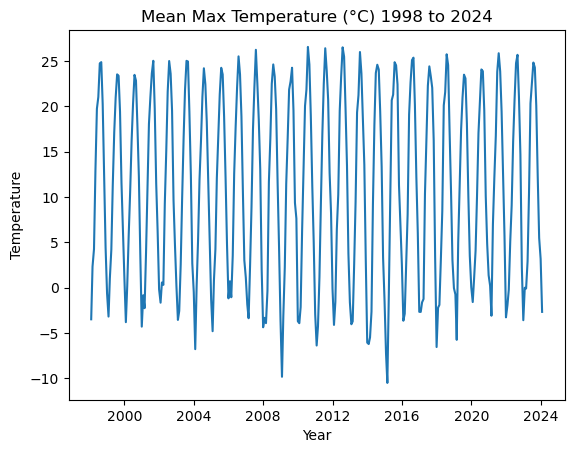

In [24]:
# plot mean max temp
plt.plot(resampled_data_M['Mean Max Temp (°C)'])
plt.title('Mean Max Temperature (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

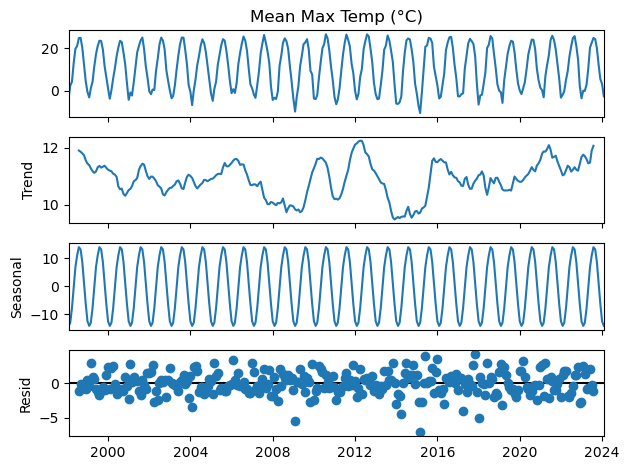

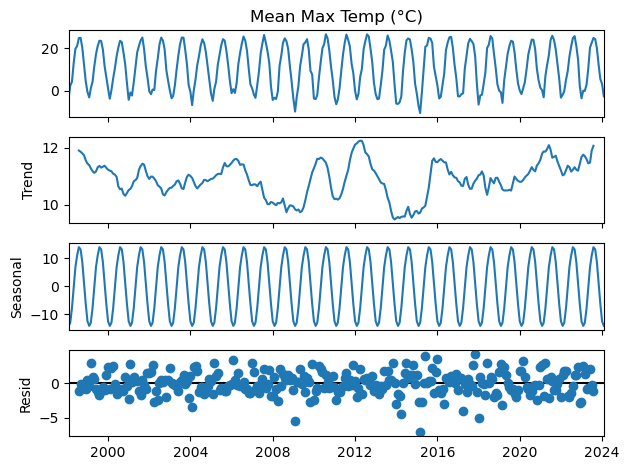

In [25]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled_data_M['Mean Max Temp (°C)'],
                            period = 12)

decomp.plot()

Dicky-Fuller test

In [26]:
adfuller_result = adfuller(resampled_data_M['Mean Max Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('\nData is stationary. Can proceed with model creation.')

(-4.1762100354997305, 0.0007227338048122296, 16, 296, {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}, 1202.8087739840373)
ADF Test Result:
Test Statistic: -4.1762100354997305
P-value: 0.0007227338048122296
Number of Lags: 16
Number of Observations: 296
Critical Values:
  1%: -3.452636878592149
  5%: -2.8713543954331433
  10%: -2.5719993576515705
Estimated maximized information criterion (aic): 1202.8087739840373

Data is stationary. Can proceed with model creation.


ACF and PACF

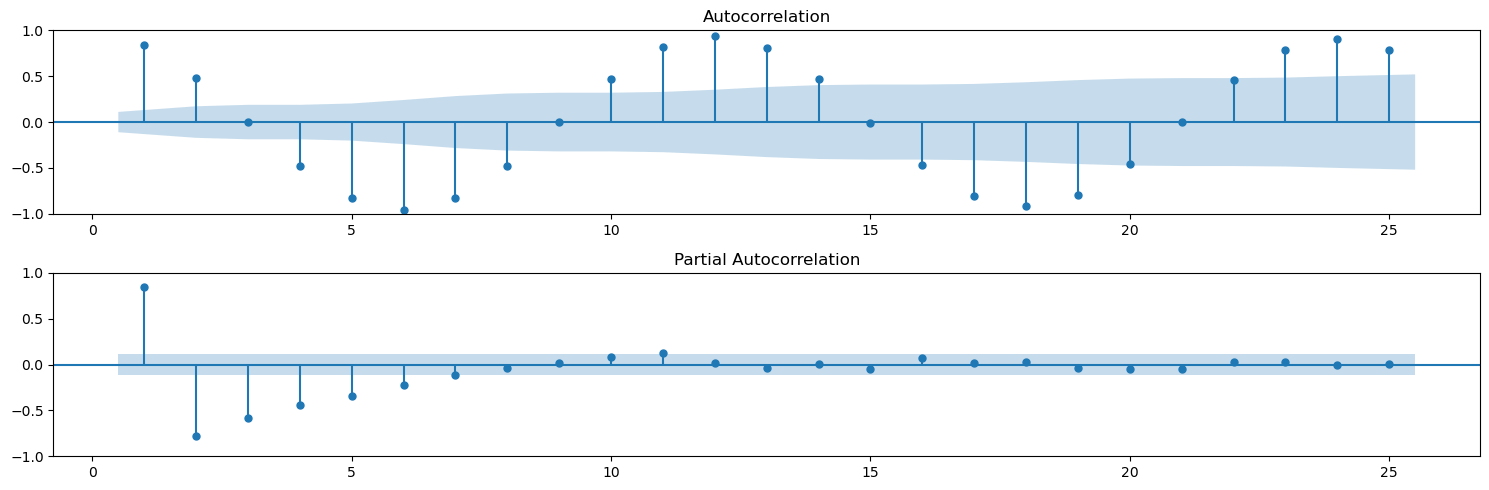

In [27]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled_data_M['Mean Max Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled_data_M['Mean Max Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

Split data to train and test dataset for model creation

In [28]:
# split data to train and test
train = resampled_data_M.loc[resampled_data_M.index <= '2019-01-01']
test = resampled_data_M.loc[resampled_data_M.index > '2019-01-01']

print(resampled_data_M.shape)
print(train.shape)
print(test.shape)
print(test.index.max())

(313, 25)
(252, 25)
(61, 25)
2024-01-31 00:00:00


In [29]:
# Create empty list to store search results
order_aic_bic_arima=[]
# Loop over p values from 0-4 (Use the partial autocorrelation)
for p in range(5):
# Loop over q values from 0-4 (Use the autocorrelation)
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(resampled_data_M['Mean Max Temp (°C)'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic_arima.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)
            
# Construct DataFrame from order_aic_bic
order_df_arima = pd.DataFrame(order_aic_bic_arima,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df_arima.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df_arima.sort_values('BIC'))

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\t

    p  q          AIC          BIC
13  2  3  1270.087936  1296.311358
17  3  2  1270.656491  1296.879913
23  4  3  1273.000223  1306.716052
19  3  4  1274.162579  1307.878408
12  2  2  1275.784486  1298.261705
22  4  2  1275.848743  1305.818368
18  3  3  1279.682416  1309.652042
24  4  4  1283.090274  1320.552306
21  4  1  1351.577748  1377.801171
16  3  1  1375.499187  1397.976406
20  4  0  1416.599113  1439.076333
11  2  1  1417.351288  1436.082304
15  3  0  1499.216721  1517.947737
10  2  0  1627.145821  1642.130634
14  2  4  1666.848409  1696.818035
4   0  4  1728.973079  1751.450298
9   1  4  1759.440985  1785.664407
7   1  2  1761.225743  1779.956759
3   0  3  1787.366542  1806.097558
6   1  1  1828.325494  1843.310307
8   1  3  1857.282931  1879.760151
2   0  2  1878.388342  1893.373155
5   1  0  1961.151580  1972.390190
1   0  1  2051.946699  2063.185309
0   0  0  2352.155684  2359.648090
    p  q          AIC          BIC
13  2  3  1270.087936  1296.311358
17  3  2  1270.65649

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
# ARIMA #

parameter = order_df_arima[(order_df_arima['AIC'] == order_df_arima['AIC'].min()) & (order_df_arima['BIC'] == order_df_arima['BIC'].min())]
print(parameter)
p = parameter['p'].iloc[0]
print(p)
q = parameter['q'].iloc[0]
print(q)

# Instantiate the model
# model_arima = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(parameter['p'].iloc[0], 0, parameter['q'].iloc[0])) #order=(p,d,q)
model_arima = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(p, 0, q)) #order=(p,d,q)

# Fit the model
results_train_arima = model_arima.fit()

# Print model fit summary
print(results_train_arima.summary())

    p  q          AIC          BIC
13  2  3  1270.087936  1296.311358
2
3
                               SARIMAX Results                                
Dep. Variable:     Mean Max Temp (°C)   No. Observations:                  252
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -502.715
Date:                Mon, 01 Apr 2024   AIC                           1019.431
Time:                        21:56:04   BIC                           1044.137
Sample:                    01-31-1998   HQIC                          1029.372
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8321      0.154     70.181      0.000      10.530      11.135
ar.L1          1.7321      0.001   2773.159      0.000   

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
# Create empty list to store search results
order_aic_bic_sarimax = []

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(
                            resampled_data_M['Mean Max Temp (°C)'],
                            order=(p, 0, q),
                            seasonal_order=(P, D, Q, 12),
                            trend='c'
                        )
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\s

Error: LU decomposition error.


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\states

In [32]:
# Construct DataFrame from order_aic_bic
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                        columns=['p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df_sarimax.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df_sarimax.sort_values('BIC'))

     p  q  P  D  Q          AIC          BIC
48   1  0  0  1  2  1233.698583  1252.234134
120  1  0  1  1  1  1234.049861  1252.585412
39   1  0  0  1  1  1234.166217  1248.994659
46   0  1  0  1  2  1234.391440  1252.926991
200  1  0  2  1  1  1234.645033  1256.887695
..  .. .. .. .. ..          ...          ...
2    0  2  0  0  0  1878.388342  1893.373155
3    1  0  0  0  0  1961.151580  1972.390190
1    0  1  0  0  0  2051.946699  2063.185309
9    0  0  0  0  1  2052.501836  2063.740445
0    0  0  0  0  0  2352.155684  2359.648090

[242 rows x 7 columns]
     p  q  P  D  Q          AIC          BIC
39   1  0  0  1  1  1234.166217  1248.994659
37   0  1  0  1  1  1234.817297  1249.645738
48   1  0  0  1  2  1233.698583  1252.234134
120  1  0  1  1  1  1234.049861  1252.585412
46   0  1  0  1  2  1234.391440  1252.926991
..  .. .. .. .. ..          ...          ...
2    0  2  0  0  0  1878.388342  1893.373155
3    1  0  0  0  0  1961.151580  1972.390190
1    0  1  0  0  0  2051.946699

In [33]:
# SARIMAX #

min_aic_parameters = order_df_sarimax[order_df_sarimax['AIC'] == order_df_sarimax['AIC'].min()]
parameter = min_aic_parameters[min_aic_parameters['BIC'] == min_aic_parameters['BIC'].min()]
print(parameter)
p = parameter['p'].iloc[0]
print(p)
q = parameter['q'].iloc[0]
print(q)
P = parameter['P'].iloc[0]
print(P)
D = parameter['D'].iloc[0]
print(D)
Q = parameter['Q'].iloc[0]
print(Q)


# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Mean Max Temp (°C)'], order=(p, 0, q),
                               seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())

    p  q  P  D  Q          AIC          BIC
48  1  0  0  1  2  1233.698583  1252.234134
1
0
0
1
2


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:                      Mean Max Temp (°C)   No. Observations:                  252
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -486.791
Date:                                 Mon, 01 Apr 2024   AIC                            981.582
Time:                                         22:17:52   BIC                            995.505
Sample:                                     01-31-1998   HQIC                           987.192
                                          - 12-31-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2208      0.062      3.590      0.000       0.100       0

In [34]:
# Make predictions
arima_predictions = results_train_arima.predict(start=test['Mean Max Temp (°C)'].index[0], 
                                         end=test['Mean Max Temp (°C)'].index[-1], 
                                         typ='levels')
print(arima_predictions)

sarimax_predictions = results_train_sarimax.predict(start=test['Mean Max Temp (°C)'].index[0],
                                             end=test['Mean Max Temp (°C)'].index[-1], 
                                             typ='levels')
print(sarimax_predictions)

2019-01-31    -4.240259
2019-02-28    -3.266305
2019-03-31     1.817872
2019-04-30     9.316162
2019-05-31    17.220017
                ...    
2023-09-30    19.894116
2023-10-31    12.422827
2023-11-30     4.525932
2023-12-31    -1.681379
2024-01-31    -4.536600
Freq: M, Name: predicted_mean, Length: 61, dtype: float64
2019-01-31    -3.305649
2019-02-28    -2.909840
2019-03-31     2.070001
2019-04-30     9.708181
2019-05-31    18.634988
                ...    
2023-09-30    19.748397
2023-10-31    12.387831
2023-11-30     4.519090
2023-12-31    -2.024742
2024-01-31    -3.977315
Freq: M, Name: predicted_mean, Length: 61, dtype: float64


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [35]:
# to calculate MAE< MAPE and RSME
arima_MAE = mean_absolute_error(test['Mean Max Temp (°C)'], arima_predictions)
print('Arima_MAE:', arima_MAE)
arima_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'], arima_predictions)
print('Arima_MAPE:', arima_MAPE)
arima_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'], arima_predictions))
print('Arima_RMSE:', arima_RMSE)


sarimax_MAE = mean_absolute_error(test['Mean Max Temp (°C)'], sarimax_predictions)
print('Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'], sarimax_predictions)
print('Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'], sarimax_predictions))
print('Sarimax_RMSE:', sarimax_RMSE)



Arima_MAE: 1.855213586476002
Arima_MAPE: 37.00963588498497
Arima_RMSE: 2.275441683198399
Sarimax_MAE: 1.6577258598222142
Sarimax_MAPE: 32.55012113836236
Sarimax_RMSE: 2.064272882389796


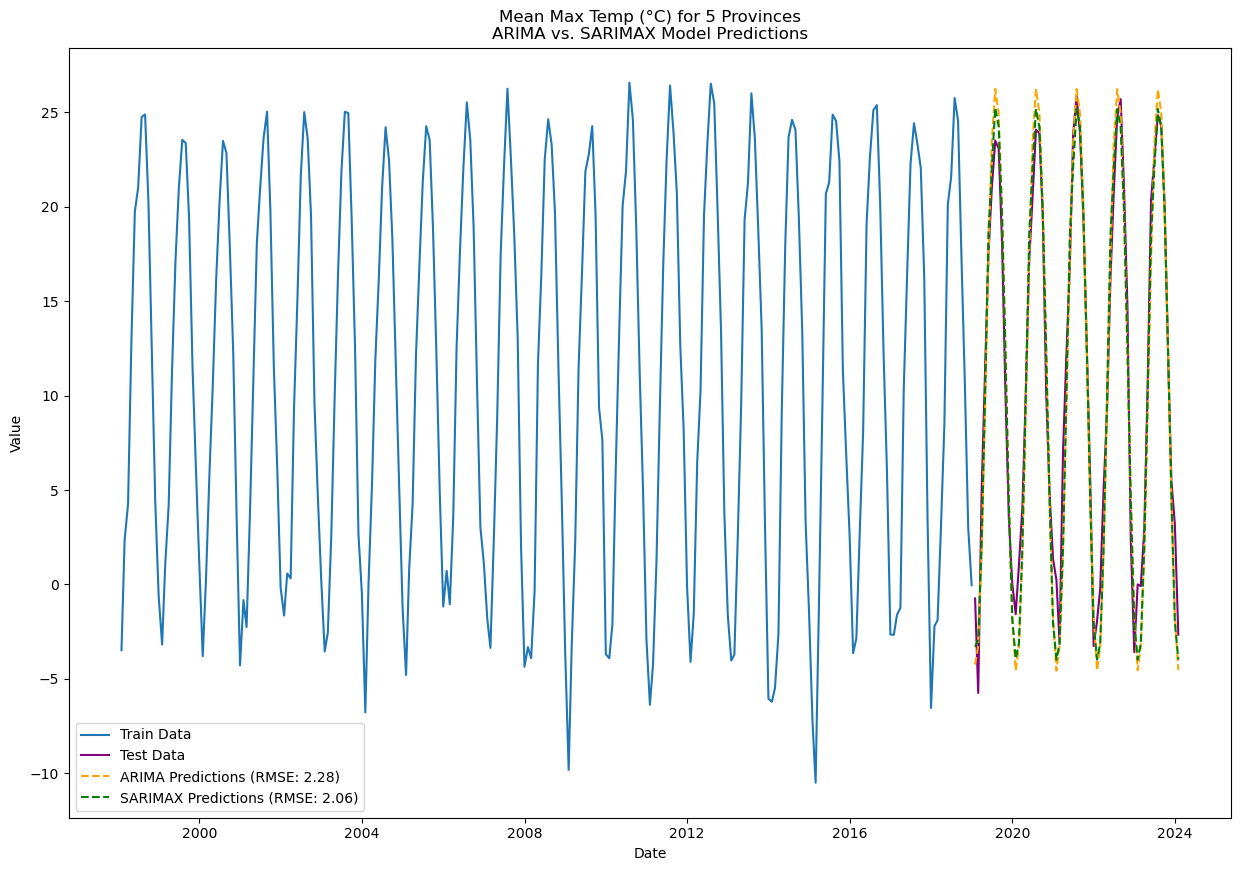

In [36]:
# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Max Temp (°C)'].index, train['Mean Max Temp (°C)'], label='Train Data')

plt.plot(test['Mean Max Temp (°C)'].index, test['Mean Max Temp (°C)'], label='Test Data',
         color = 'purple')

plt.plot(test['Mean Max Temp (°C)'].index, arima_predictions, 
         label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})',
         linestyle='--',
         alpha=1.0,
         color = 'orange')

plt.plot(test['Mean Max Temp (°C)'].index, sarimax_predictions, 
         label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})',
         linestyle='--',
         alpha=1.0,
         color = 'green')

plt.title('Mean Max Temp (°C) for 5 Provinces\nARIMA vs. SARIMAX Model Predictions',)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

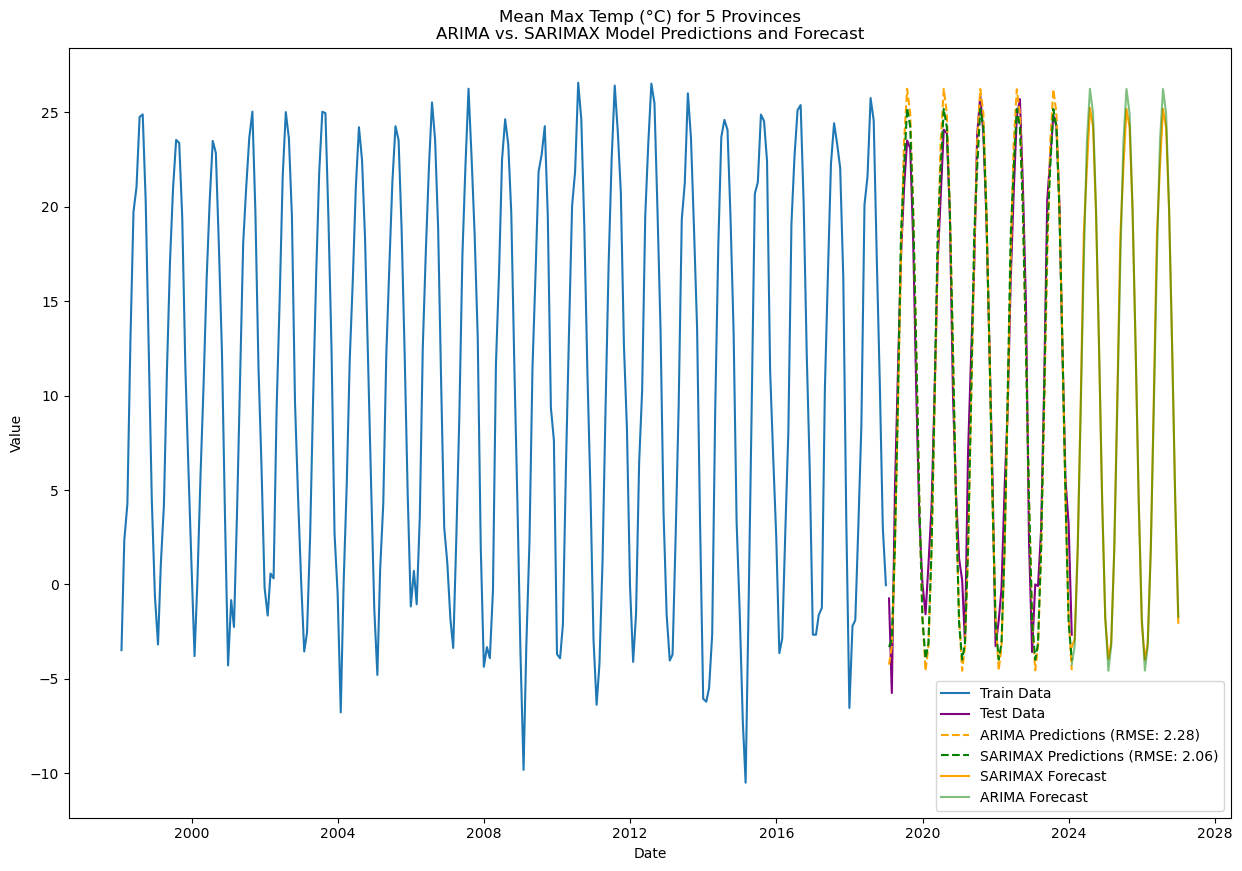

In [37]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')

# Get ARIMA forecast for future dates
arima_forecast = results_train_arima.get_forecast(steps=36)

# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Max Temp (°C)'].index, train['Mean Max Temp (°C)'], label='Train Data')
plt.plot(test['Mean Max Temp (°C)'].index, test['Mean Max Temp (°C)'], label='Test Data', color='purple')
plt.plot(test['Mean Max Temp (°C)'].index, arima_predictions, label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})', linestyle='--', alpha=1.0, color='orange')
plt.plot(test['Mean Max Temp (°C)'].index, sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', linestyle='--', alpha=1.0, color='green')

# Plot SARIMAX forecast for future dates
plt.plot(future_dates, sarimax_forecast.predicted_mean, label='SARIMAX Forecast', color='orange')
# Plot SARIMAX forecast for future dates
plt.plot(future_dates, arima_forecast.predicted_mean, label='ARIMA Forecast', alpha=.5, color='green')


plt.title('Mean Max Temp (°C) for 5 Provinces\nARIMA vs. SARIMAX Model Predictions and Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**(1.2) Forecasting: Mean Min Temp (°C)**

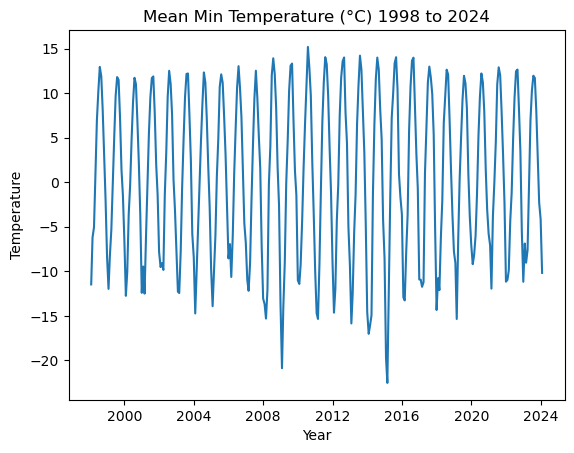

In [38]:
# plot mean min temp
plt.plot(resampled_data_M['Mean Min Temp (°C)'])
plt.title('Mean Min Temperature (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

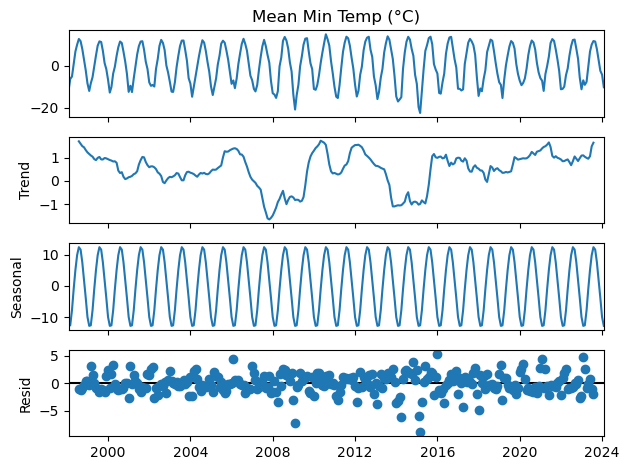

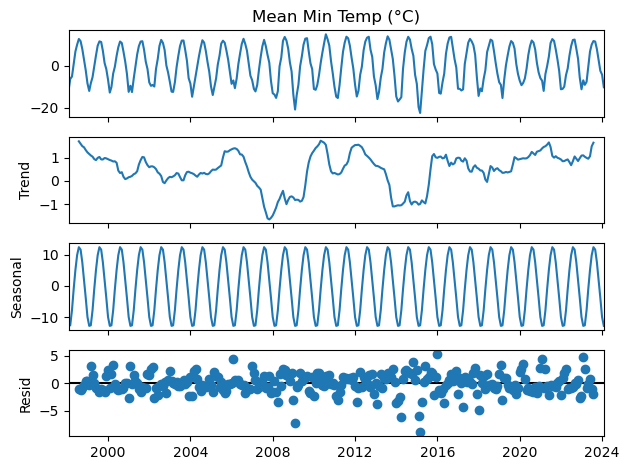

In [39]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled_data_M['Mean Min Temp (°C)'],
                            period = 12)

decomp.plot()

Dicky-Fuller test

In [40]:
adfuller_result = adfuller(resampled_data_M['Mean Min Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('\nData is stationary. Can proceed with model creation.')

(-3.6253782996548773, 0.005293978506534719, 16, 296, {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}, 1234.6043305167136)
ADF Test Result:
Test Statistic: -3.6253782996548773
P-value: 0.005293978506534719
Number of Lags: 16
Number of Observations: 296
Critical Values:
  1%: -3.452636878592149
  5%: -2.8713543954331433
  10%: -2.5719993576515705
Estimated maximized information criterion (aic): 1234.6043305167136

Data is stationary. Can proceed with model creation.


ACF and PACF

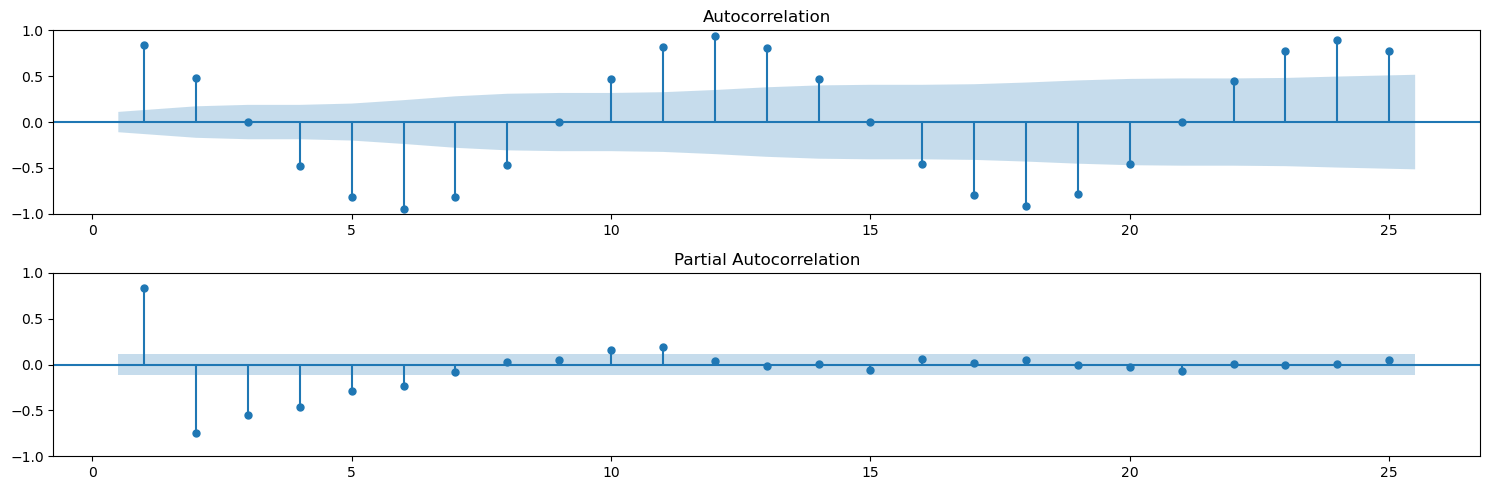

In [41]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled_data_M['Mean Min Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled_data_M['Mean Min Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

Split data to train and test dataset for model creation

In [42]:
# split data to train and test
train = resampled_data_M.loc[resampled_data_M.index <= '2019-01-01']
test = resampled_data_M.loc[resampled_data_M.index > '2019-01-01']

print(resampled_data_M.shape)
print(train.shape)
print(test.shape)
print(test.index.max())

(313, 25)
(252, 25)
(61, 25)
2024-01-31 00:00:00


In [43]:
# Create empty list to store search results
order_aic_bic_arima=[]
# Loop over p values from 0-4 (Use the partial autocorrelation)
for p in range(5):
# Loop over q values from 0-4 (Use the autocorrelation)
    for q in range(5):
        try:
            # Create and fit ARIMA(p,d,q) model
            model = sm.tsa.ARIMA(resampled_data_M['Mean Min Temp (°C)'], order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic_arima.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)
            
# Construct DataFrame from order_aic_bic
order_df_arima = pd.DataFrame(order_aic_bic_arima,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df_arima.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df_arima.sort_values('BIC'))

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\b

    p  q          AIC          BIC
13  2  3  1299.139857  1325.363279
22  4  2  1301.628088  1331.597714
14  2  4  1301.710661  1331.680287
17  3  2  1301.890504  1328.113926
19  3  4  1304.252412  1337.968241
23  4  3  1304.602037  1338.317865
18  3  3  1306.709476  1336.679102
12  2  2  1315.693677  1338.170896
24  4  4  1320.268332  1357.730364
21  4  1  1371.698453  1397.921876
16  3  1  1395.213168  1417.690387
20  4  0  1414.623251  1437.100470
11  2  1  1425.033805  1443.764821
15  3  0  1499.187512  1517.918528
10  2  0  1604.762003  1619.746816
4   0  4  1692.239848  1714.717067
9   1  4  1708.821316  1735.044738
7   1  2  1722.705317  1741.436333
3   0  3  1732.415734  1751.146750
6   1  1  1770.457685  1785.442498
8   1  3  1817.054537  1839.531756
2   0  2  1833.718677  1848.703490
5   1  0  1896.066024  1907.304634
1   0  1  1977.909785  1989.148395
0   0  0  2279.248724  2286.741130
    p  q          AIC          BIC
13  2  3  1299.139857  1325.363279
17  3  2  1301.89050

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
# ARIMA #

parameter = order_df_arima[(order_df_arima['AIC'] == order_df_arima['AIC'].min()) & (order_df_arima['BIC'] == order_df_arima['BIC'].min())]
print(parameter)
p = parameter['p'].iloc[0]
print(p)
q = parameter['q'].iloc[0]
print(q)

# Instantiate the model
# model_arima = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(parameter['p'].iloc[0], 0, parameter['q'].iloc[0])) #order=(p,d,q)
model_arima = sm.tsa.ARIMA(train['Mean Min Temp (°C)'], order=(p, 0, q)) #order=(p,d,q)

# Fit the model
results_train_arima = model_arima.fit()

# Print model fit summary
print(results_train_arima.summary())

    p  q          AIC          BIC
13  2  3  1299.139857  1325.363279
2
3
                               SARIMAX Results                                
Dep. Variable:     Mean Min Temp (°C)   No. Observations:                  252
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -520.927
Date:                Mon, 01 Apr 2024   AIC                           1055.853
Time:                        22:22:07   BIC                           1080.559
Sample:                    01-31-1998   HQIC                          1065.794
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4081      0.211      1.937      0.053      -0.005       0.821
ar.L1          1.7319      0.001   1583.433      0.000   

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [46]:
# Create empty list to store search results
order_aic_bic_sarimax = []

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(
                            resampled_data_M['Mean Min Temp (°C)'],
                            order=(p, 0, q),
                            seasonal_order=(P, D, Q, 12),
                            trend='c'
                        )
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\s

In [47]:
# Construct DataFrame from order_aic_bic
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                        columns=['p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df_sarimax.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df_sarimax.sort_values('BIC'))

     p  q  P  D  Q          AIC          BIC
48   1  0  0  1  2  1276.674452  1295.210003
201  1  0  2  1  1  1277.119799  1299.362460
120  1  0  1  1  1  1277.538645  1296.074196
129  1  0  1  1  2  1278.107652  1300.350314
52   2  1  0  1  2  1278.572400  1304.522172
..  .. .. .. .. ..          ...          ...
2    0  2  0  0  0  1833.718677  1848.703489
3    1  0  0  0  0  1896.066024  1907.304633
1    0  1  0  0  0  1977.909785  1989.148395
9    0  0  0  0  1  1992.588665  2003.827274
0    0  0  0  0  0  2279.248724  2286.741130

[243 rows x 7 columns]
     p  q  P  D  Q          AIC          BIC
39   1  0  0  1  1  1279.319936  1294.148377
48   1  0  0  1  2  1276.674452  1295.210003
120  1  0  1  1  1  1277.538645  1296.074196
37   0  1  0  1  1  1282.460184  1297.288625
46   0  1  0  1  2  1279.088571  1297.624122
..  .. .. .. .. ..          ...          ...
2    0  2  0  0  0  1833.718677  1848.703489
3    1  0  0  0  0  1896.066024  1907.304633
1    0  1  0  0  0  1977.909785

In [48]:
# SARIMAX #

min_aic_parameters = order_df_sarimax[order_df_sarimax['AIC'] == order_df_sarimax['AIC'].min()]
parameter = min_aic_parameters[min_aic_parameters['BIC'] == min_aic_parameters['BIC'].min()]
print(parameter)
p = parameter['p'].iloc[0]
print(p)
q = parameter['q'].iloc[0]
print(q)
P = parameter['P'].iloc[0]
print(P)
D = parameter['D'].iloc[0]
print(D)
Q = parameter['Q'].iloc[0]
print(Q)


# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Mean Min Temp (°C)'], order=(p, 0, q),
                               seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())

    p  q  P  D  Q          AIC          BIC
48  1  0  0  1  2  1276.674452  1295.210003
1
0
0
1
2


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:                      Mean Min Temp (°C)   No. Observations:                  252
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -507.685
Date:                                 Mon, 01 Apr 2024   AIC                           1023.369
Time:                                         22:55:48   BIC                           1037.292
Sample:                                     01-31-1998   HQIC                          1028.979
                                          - 12-31-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3512      0.050      7.048      0.000       0.254       0

In [49]:
# Make predictions
arima_predictions = results_train_arima.predict(start=test['Mean Min Temp (°C)'].index[0], 
                                         end=test['Mean Min Temp (°C)'].index[-1], 
                                         typ='levels')
print(arima_predictions)

sarimax_predictions = results_train_sarimax.predict(start=test['Mean Min Temp (°C)'].index[0],
                                             end=test['Mean Min Temp (°C)'].index[-1], 
                                             typ='levels')
print(sarimax_predictions)

2019-01-31   -12.409000
2019-02-28   -12.223920
2019-03-31    -7.978080
2019-04-30    -1.486193
2019-05-31     5.512018
                ...    
2023-09-30     8.755100
2023-10-31     2.295884
2023-11-30    -4.667928
2023-12-31   -10.270495
2024-01-31   -13.011022
Freq: M, Name: predicted_mean, Length: 61, dtype: float64
2019-01-31   -12.128313
2019-02-28   -12.605579
2019-03-31    -7.715398
2019-04-30    -1.107269
2019-05-31     6.144186
                ...    
2023-09-30     8.273068
2023-10-31     2.708651
2023-11-30    -3.335963
2023-12-31    -9.748842
2024-01-31   -13.409781
Freq: M, Name: predicted_mean, Length: 61, dtype: float64


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [50]:
# to calculate MAE< MAPE and RSME
arima_MAE = mean_absolute_error(test['Mean Min Temp (°C)'], arima_predictions)
print('Arima_MAE:', arima_MAE)
arima_MAPE = mean_absolute_percentage_error(test['Mean Min Temp (°C)'], arima_predictions)
print('Arima_MAPE:', arima_MAPE)
arima_RMSE = np.sqrt(mean_squared_error(test['Mean Min Temp (°C)'], arima_predictions))
print('Arima_RMSE:', arima_RMSE)


sarimax_MAE = mean_absolute_error(test['Mean Min Temp (°C)'], sarimax_predictions)
print('Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test['Mean Min Temp (°C)'], sarimax_predictions)
print('Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test['Mean Min Temp (°C)'], sarimax_predictions))
print('Sarimax_RMSE:', sarimax_RMSE)



Arima_MAE: 1.7835211010067973
Arima_MAPE: 0.7250181568134052
Arima_RMSE: 2.3013624648923328
Sarimax_MAE: 1.6346119578148577
Sarimax_MAPE: 0.5458339363230127
Sarimax_RMSE: 2.267291231893572


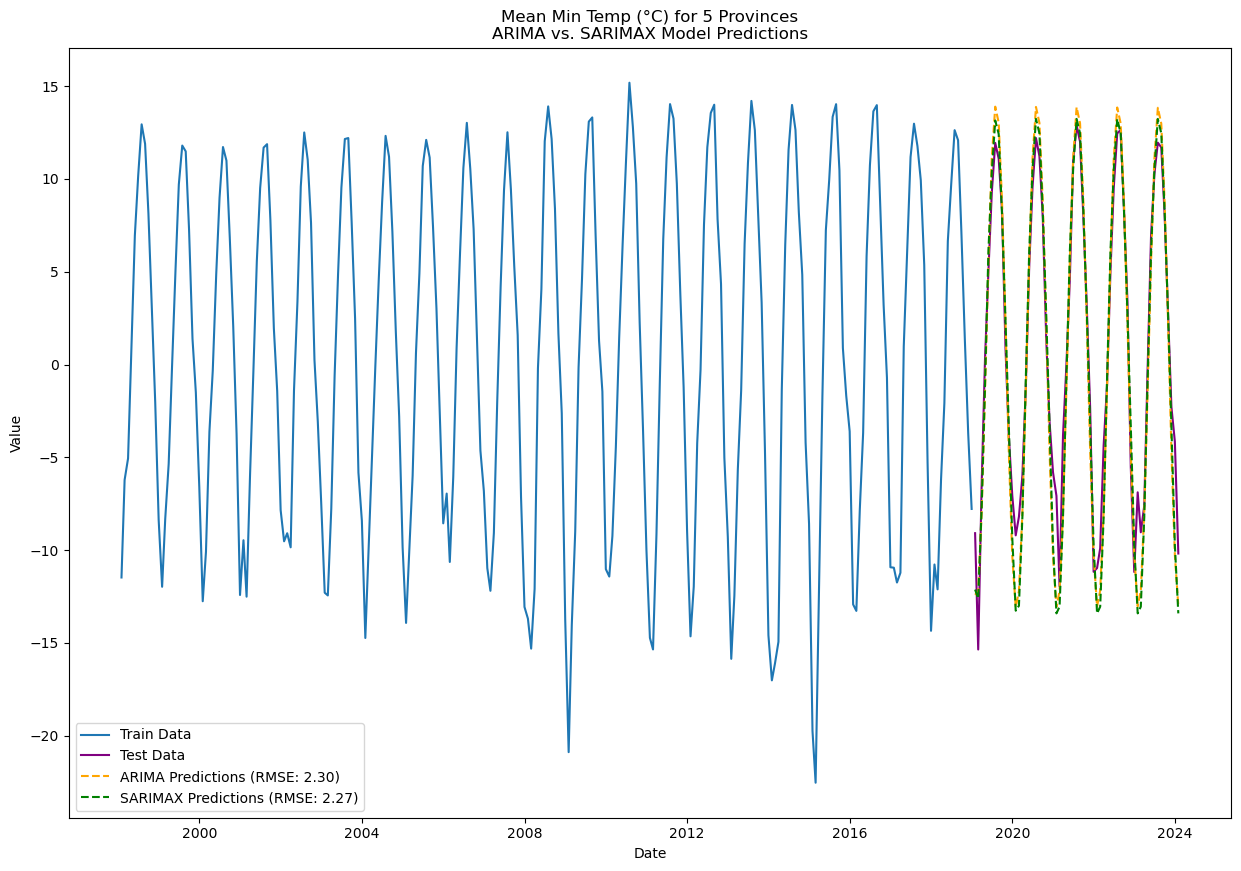

In [51]:
# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Min Temp (°C)'].index, train['Mean Min Temp (°C)'], label='Train Data')

plt.plot(test['Mean Min Temp (°C)'].index, test['Mean Min Temp (°C)'], label='Test Data',
         color = 'purple')

plt.plot(test['Mean Min Temp (°C)'].index, arima_predictions, 
         label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})',
         linestyle='--',
         alpha=1.0,
         color = 'orange')

plt.plot(test['Mean Min Temp (°C)'].index, sarimax_predictions, 
         label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})',
         linestyle='--',
         alpha=1.0,
         color = 'green')

plt.title('Mean Min Temp (°C) for 5 Provinces\nARIMA vs. SARIMAX Model Predictions',)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

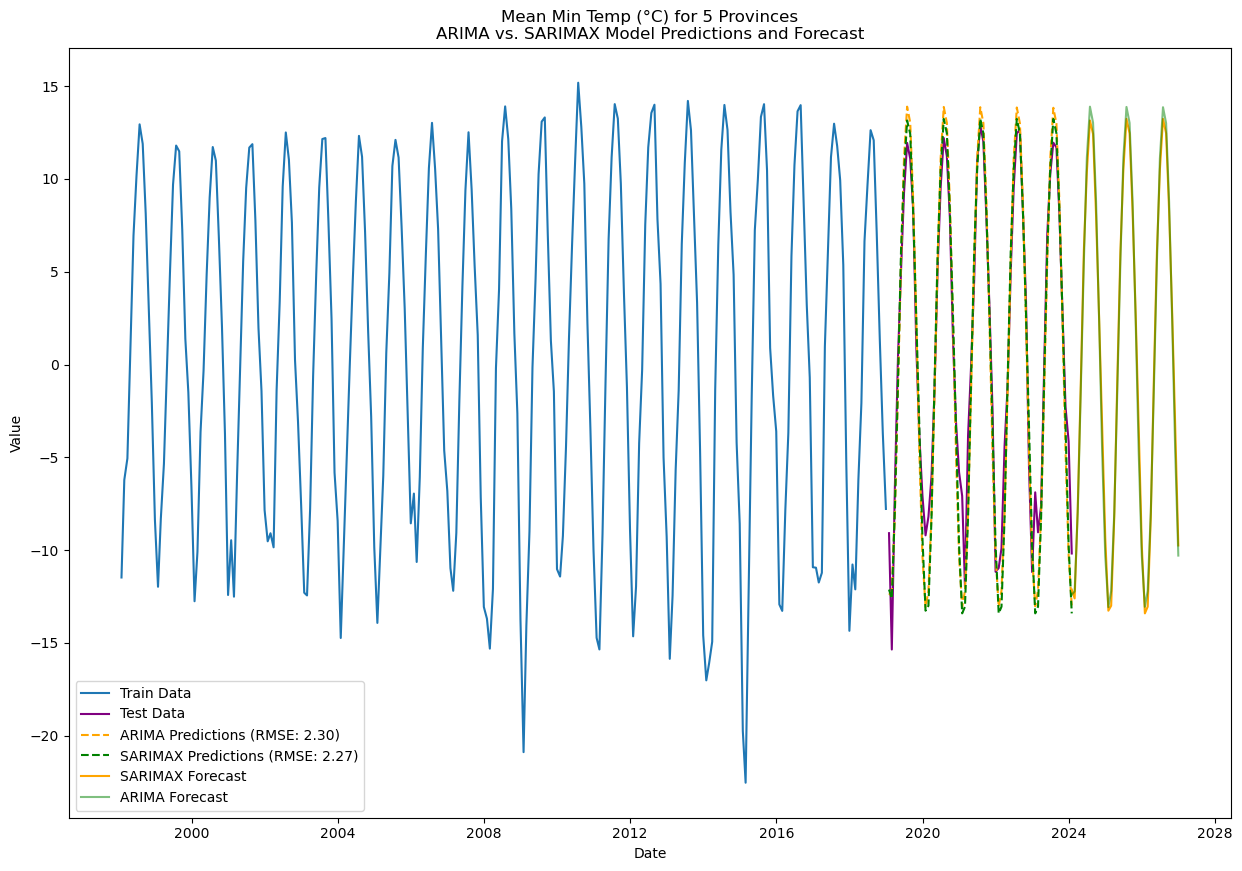

In [52]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')

# Get ARIMA forecast for future dates
arima_forecast = results_train_arima.get_forecast(steps=36)

# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Min Temp (°C)'].index, train['Mean Min Temp (°C)'], label='Train Data')
plt.plot(test['Mean Min Temp (°C)'].index, test['Mean Min Temp (°C)'], label='Test Data', color='purple')
plt.plot(test['Mean Min Temp (°C)'].index, arima_predictions, label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})', linestyle='--', alpha=1.0, color='orange')
plt.plot(test['Mean Min Temp (°C)'].index, sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', linestyle='--', alpha=1.0, color='green')

# Plot SARIMAX forecast for future dates
plt.plot(future_dates, sarimax_forecast.predicted_mean, label='SARIMAX Forecast', color='orange')
# Plot SARIMAX forecast for future dates
plt.plot(future_dates, arima_forecast.predicted_mean, label='ARIMA Forecast', alpha=.5, color='green')


plt.title('Mean Min Temp (°C) for 5 Provinces\nARIMA vs. SARIMAX Model Predictions and Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


## Ontario ##

**Forecasting: Agriculture**

In [53]:
# to filter ON province:

ontario = df[df['provincename'] == 'Ontario']

In [54]:
ontario = ontario[ontario.index.year < 2022]

In [55]:
# split data into number and object
num_cols = ontario.select_dtypes(include = ['number'])
cat_cols = ontario.select_dtypes(include = ['object'])

# to resample num data into monthly frequency
resampled_num = num_cols.resample(rule = 'M').mean()

# to resample cat data into monthly frequency
resampled_cat = cat_cols.resample(rule = 'M').apply(lambda x: x.value_counts().idxmax())

# combine resampled num and cat data
resampled_ON = pd.concat([resampled_num, resampled_cat], axis = 1)

In [56]:
ontario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8701 entries, 1998-01-01 to 2021-12-01
Data columns (total 25 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       8701 non-null   object 
 1   Longitude                                                                          8701 non-null   float64
 2   Latitude                                                                           8701 non-null   float64
 3   Region.Name                                                                        8701 non-null   object 
 4   Construction                                                                       8701 non-null   float64
 5   Manufacturing                                                                      870

In [57]:
print(ontario.index.min())
print(ontario.index.max())

1998-01-01 00:00:00
2021-12-01 00:00:00


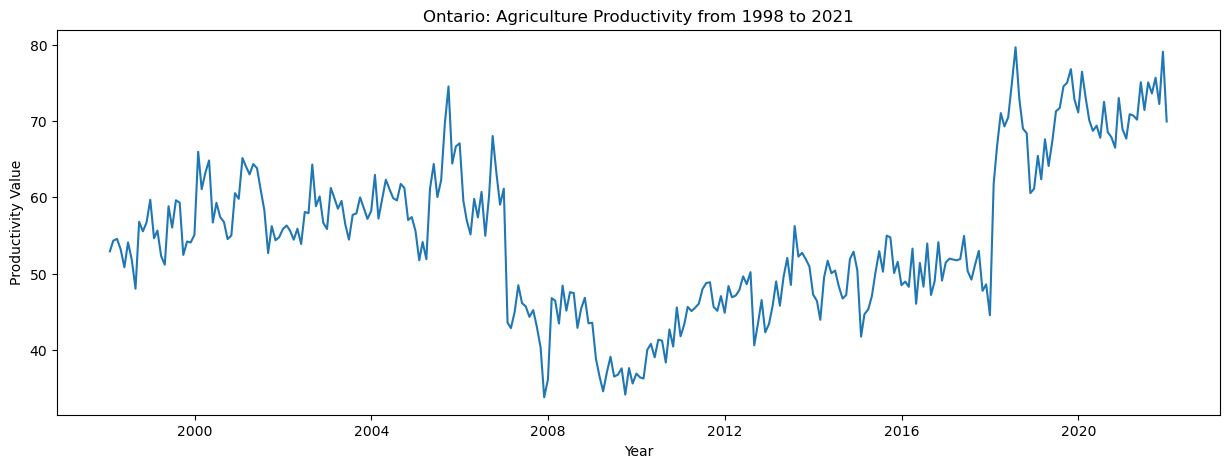

In [58]:
# plot the utililities
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
plt.title('Ontario: Agriculture Productivity from 1998 to 2021')
plt.xlabel('Year')
plt.ylabel('Productivity Value')
plt.show()

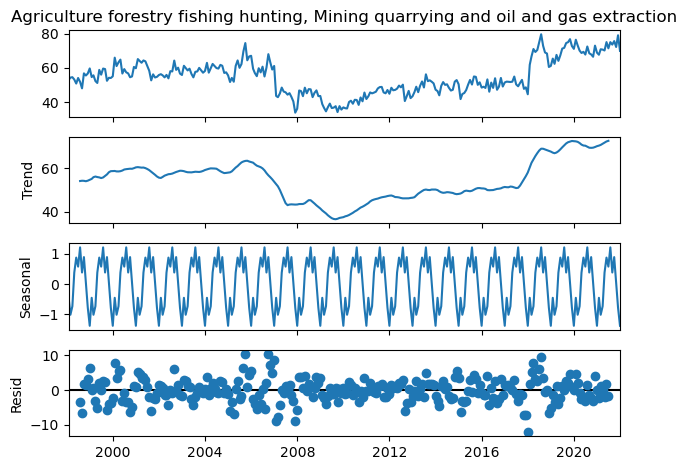

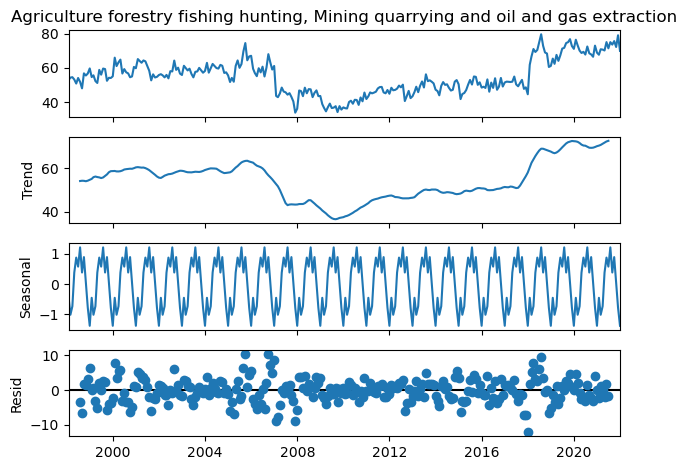

In [59]:
# to check different components (trend, seasonality, and residual)

decomp_ON = seasonal_decompose(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'],
                               period = 12)

decomp_ON.plot()

Dicky-Fuller Test

In [60]:
adfuller_result = adfuller(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
adfuller_result = adfuller(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-2.2244320044855024, 0.19749783622467093, 1, 286, {'1%': -3.4534232986669546, '5%': -2.8716994185534745, '10%': -2.5721833625116144}, 1483.2074409605557)
ADF Test Result:
Test Statistic: -2.2244320044855024
P-value: 0.19749783622467093
Number of Lags: 1
Number of Observations: 286
Critical Values:
  1%: -3.4534232986669546
  5%: -2.8716994185534745
  10%: -2.5721833625116144
Estimated maximized information criterion (aic): 1483.2074409605557
Data is non-stationary. Needs to be converted to stationary data.


In [61]:
# transforming data to stationary data

# differencing

resampled_ON_diff = resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'].diff(periods = 2).dropna()
resampled_ON_diff

Date/Time
1998-03-31    1.640896
1998-04-30   -1.110992
1998-05-31   -3.733965
1998-06-30    0.890058
1998-07-31    1.002426
                ...   
2021-08-31    2.178425
2021-09-30    0.614057
2021-10-31   -1.394894
2021-11-30    3.409796
2021-12-31   -2.291200
Freq: M, Name: Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction, Length: 286, dtype: float64

In [62]:
adfuller_result = adfuller(resampled_ON_diff)
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-4.411990290013513, 0.00028266033924551895, 14, 271, {'1%': -3.4547128138328875, '5%': -2.8722649771800155, '10%': -2.5724850011573914}, 1484.4594978642592)
ADF Test Result:
Test Statistic: -4.411990290013513
P-value: 0.00028266033924551895
Number of Lags: 14
Number of Observations: 271
Critical Values:
  1%: -3.4547128138328875
  5%: -2.8722649771800155
  10%: -2.5724850011573914
Estimated maximized information criterion (aic): 1484.4594978642592
Data is stationary. Can proceed with model creation.


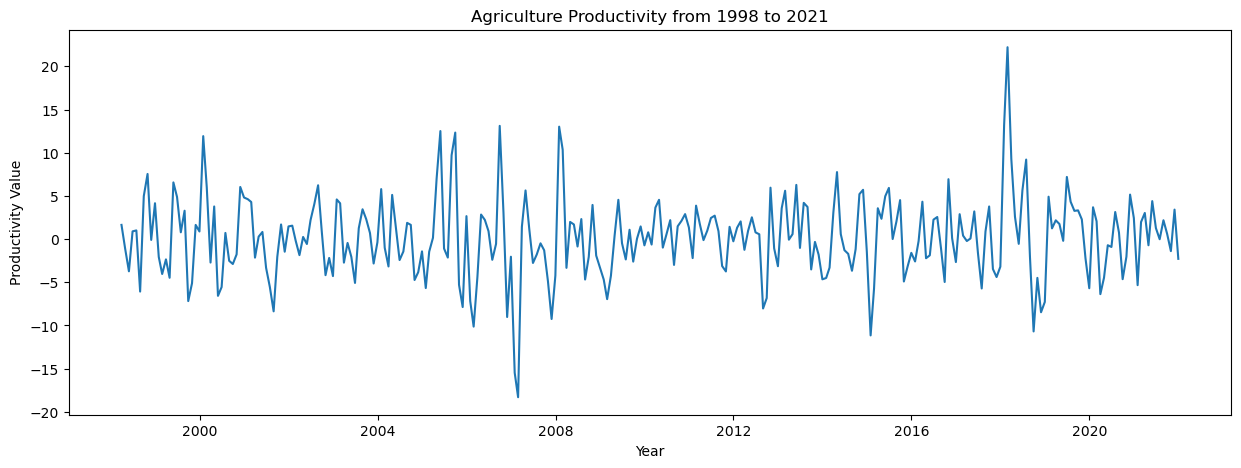

In [63]:
# plotting the transformed data

# plot the utililities
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON_diff)
plt.title('Agriculture Productivity from 1998 to 2021')
plt.xlabel('Year')
plt.ylabel('Productivity Value')
plt.show()

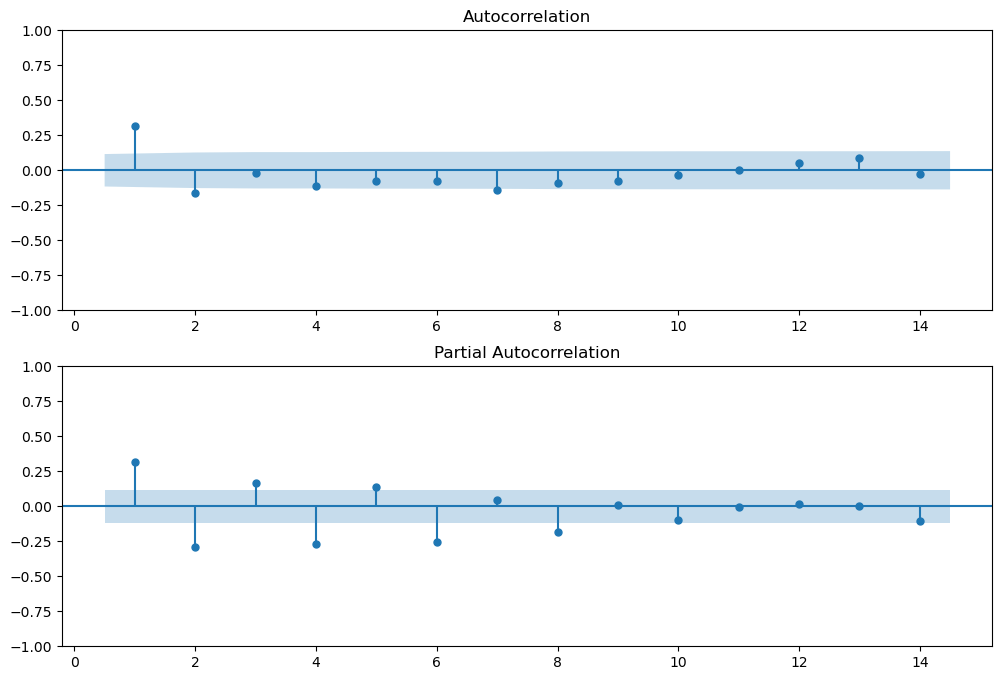

In [64]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(resampled_ON_diff, lags=14, zero=False, ax=ax1)
# plot_acf(resampled_ON_diff, zero=False, ax=ax1)

# Plot the PACF of on ax2
plot_pacf(resampled_ON_diff, lags=14, zero=False, ax=ax2)
# plot_pacf(resampled_ON_diff, zero=False, ax=ax2)

plt.show()

SARIMAX MODEL

In [65]:
# from pmdarima.arima import auto_arima

# model = auto_arima(resampled_ON_diff, start_p=1, start_q=1,
#                       test='adf',
#                       max_p=14, max_q=14,
#                       m=1,             
#                       d=0,          
#                       seasonal=False,   
#                       start_P=0, 
#                       D=None, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

In [66]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values (Use the partial autocorrelation)
for p in range(14):
# Loop over q values (Use the autocorrelation)
    for q in range(14):
        try:
            # Create and fit SARIMAX(p,d,q) model
            model = sm.tsa.SARIMAX(resampled_ON_diff, order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\state

In [67]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q          AIC          BIC
32  2  4  1565.441658  1594.689593
59  4  3  1566.219836  1599.123763
60  4  4  1566.410394  1602.970312
5   0  5  1566.918215  1592.510157
62  4  6  1567.063181  1610.935083
.. .. ..          ...          ...
56  4  0  1617.274432  1639.210383
42  3  0  1637.087636  1655.367595
28  2  0  1643.554348  1658.178315
14  1  0  1667.317647  1678.285623
0   0  0  1695.993818  1703.305802

[196 rows x 4 columns]
      p   q          AIC          BIC
2     0   2  1569.495489  1584.119456
16    1   2  1568.097078  1586.377037
15    1   1  1571.952662  1586.576630
30    2   2  1567.219652  1589.155603
29    2   1  1570.902784  1589.182743
..   ..  ..          ...          ...
193  13  11  1585.711275  1680.767062
180  12  12  1587.024276  1682.080063
194  13  12  1589.525255  1688.237034
195  13  13  1589.634709  1692.002480
0     0   0  1695.993818  1703.305802

[196 rows x 4 columns]


In [68]:
#to check the minimum value in the dataframe
print("AIC_min:", order_df.AIC.min())

#to check the minimum value in the dataframe
print('BIC_min:', order_df.BIC.min())

AIC_min: 1565.4416584279572
BIC_min: 1584.119455815274


In [69]:
# Instantiate the model

model = sm.tsa.SARIMAX(resampled_ON_diff, order=(2, 0, 4)) #order=(p,d,q)

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                                                               SARIMAX Results                                                               
Dep. Variable:     Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction   No. Observations:                  286
Model:                                                                              SARIMAX(2, 0, 4)   Log Likelihood                -774.931
Date:                                                                               Mon, 01 Apr 2024   AIC                           1563.862
Time:                                                                                       23:10:34   BIC                           1589.454
Sample:                                                                                   03-31-1998   HQIC                          1574.120
                                                                                        - 12-31-2021                                         
Covari

In [70]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

confidence_intervals.head().T
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction']
upper_limits = confidence_intervals.loc[:,'upper Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction']

# Print best estimate predictions
print(mean_forecast)

Date/Time
2018-01-31    -1.868159
2018-02-28    12.183818
2018-03-31     2.872523
2018-04-30     1.024483
2018-05-31    -2.195906
2018-06-30    -1.542246
2018-07-31     1.632003
2018-08-31    -0.151058
2018-09-30    -7.020578
2018-10-31    -5.362755
2018-11-30    -1.075766
2018-12-31    -7.053480
2019-01-31     1.516113
2019-02-28     3.191211
2019-03-31    -0.522827
2019-04-30     4.882944
2019-05-31    -0.123655
2019-06-30     3.676642
2019-07-31     4.953293
2019-08-31     0.427022
2019-09-30     3.141274
2019-10-31    -0.635928
2019-11-30     1.058332
2019-12-31    -4.766914
2020-01-31    -1.831696
2020-02-29     1.721384
2020-03-31    -3.701273
2020-04-30    -4.064375
2020-05-31    -1.134354
2020-06-30    -0.528222
2020-07-31    -0.590195
2020-08-31     3.111674
2020-09-30    -1.757663
2020-10-31     0.026091
2020-11-30     1.050431
2020-12-31     5.172038
2021-01-31    -1.429212
2021-02-28    -0.510798
2021-03-31     3.913524
2021-04-30    -0.643512
2021-05-31     0.431101
2021-0

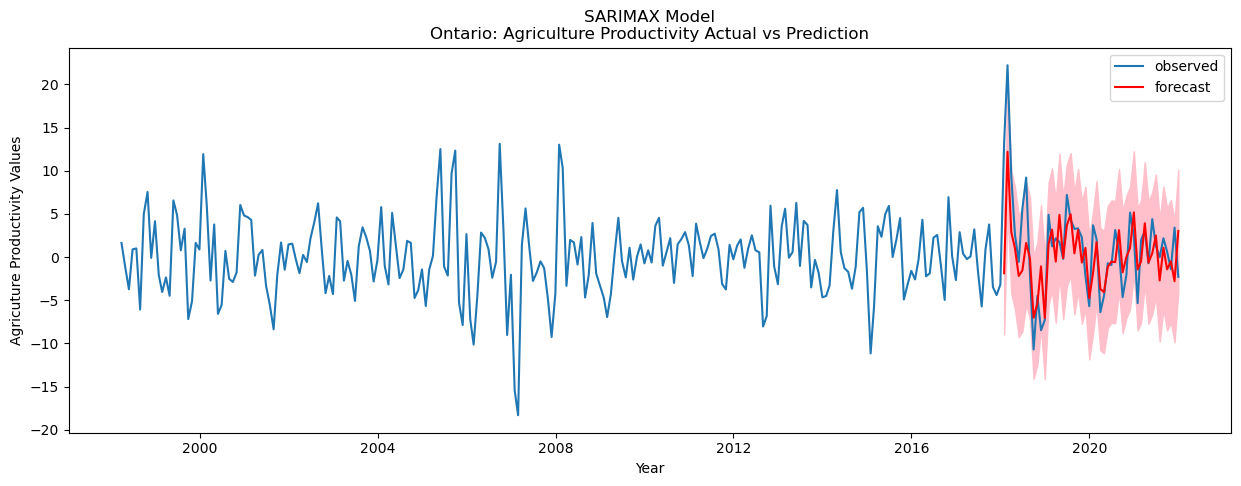

In [71]:
# plot the  data
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON_diff.index, resampled_ON_diff, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
               upper_limits, color='pink')

# set labels, legends and show plot
plt.title('SARIMAX Model\nOntario: Agriculture Productivity Actual vs Prediction')
plt.xlabel('Year')
plt.ylabel('Agricuture Productivity Values')
plt.legend()
plt.show()

In [72]:
# to calculate MAE, MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sarimax_MAE = mean_absolute_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast)
print('Sarimax_MAE:', sarimax_MAE)

sarimax_MAPE = mean_absolute_percentage_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast)
print('Sarimax_MAPE:', sarimax_MAPE)

sarimax_RMSE = np.sqrt(mean_squared_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast))
print('Sarimax_RMSE:', sarimax_RMSE)


Sarimax_MAE: 3.0718825648925105
Sarimax_MAPE: 3.5399474047469717
Sarimax_RMSE: 4.190332666109481


IGNORE BELOW

Split data to train and test dataset

In [73]:
# split data to train and test

train = resampled_ON_diff.loc[resampled_ON_diff.index <= '2020-01-01']
test = resampled_ON_diff.loc[resampled_ON_diff.index > '2020-01-01']

In [74]:
#to fit the model after splitting the data

# Instantiate the model
model = sm.tsa.ARIMA(train, order=(1, 1, 2)) #order=(p,d,q)

# Fit the model
results = model.fit()


In [75]:
#get the predictions
predictions = results.get_forecast(steps=24)
# Extract prediction mean
mean_predictions =predictions.predicted_mean
print(mean_predictions)

2020-01-31   -1.047747
2020-02-29    0.411891
2020-03-31    0.078637
2020-04-30    0.154723
2020-05-31    0.137352
2020-06-30    0.141318
2020-07-31    0.140412
2020-08-31    0.140619
2020-09-30    0.140572
2020-10-31    0.140583
2020-11-30    0.140580
2020-12-31    0.140581
2021-01-31    0.140581
2021-02-28    0.140581
2021-03-31    0.140581
2021-04-30    0.140581
2021-05-31    0.140581
2021-06-30    0.140581
2021-07-31    0.140581
2021-08-31    0.140581
2021-09-30    0.140581
2021-10-31    0.140581
2021-11-30    0.140581
2021-12-31    0.140581
Freq: M, Name: predicted_mean, dtype: float64


In [76]:
test.loc['2020-01-31': '2021-12-31']

Date/Time
2020-01-31    3.679435
2020-02-29    2.061321
2020-03-31   -6.376970
2020-04-30   -4.479538
2020-05-31   -0.716047
2020-06-30   -0.913497
2020-07-31    3.130181
2020-08-31    0.742083
2020-09-30   -4.645830
2020-10-31   -2.043999
2020-11-30    5.147226
2020-12-31    2.429975
2021-01-31   -5.337960
2021-02-28    1.969515
2021-03-31    3.022793
2021-04-30   -0.717823
2021-05-31    4.392208
2021-06-30    1.269769
2021-07-31   -0.021380
2021-08-31    2.178425
2021-09-30    0.614057
2021-10-31   -1.394894
2021-11-30    3.409796
2021-12-31   -2.291200
Freq: M, Name: Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction, dtype: float64

In [77]:
# to calculate MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

arima_MAE = mean_absolute_error(test, mean_predictions)
print('Arima_MAE:', arima_MAE)

arima_MAPE = mean_absolute_percentage_error(test, mean_predictions)
print('Arima_MAPE:', arima_MAPE)

arima_RMSE = np.sqrt(mean_squared_error(test, mean_predictions))
print('Arima_RMSE:', arima_RMSE)


Arima_MAE: 2.648816948157504
Arima_MAPE: 1.27592026524311
Arima_RMSE: 3.178484983346455


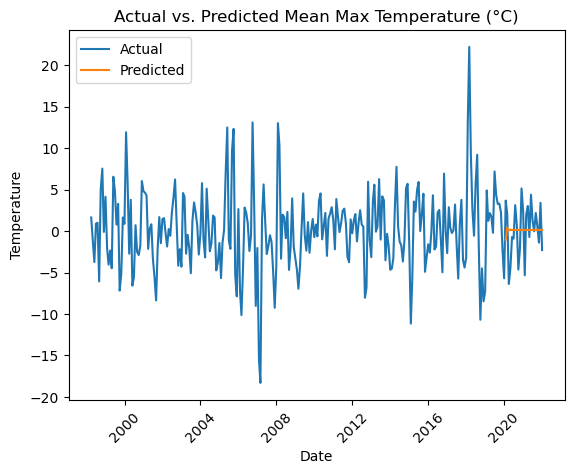

In [78]:
# plot actual data and predictions

plt.plot(resampled_ON_diff.index, resampled_ON_diff, label='Actual')

plt.plot(mean_predictions.index, mean_predictions.values, label='Predicted')

plt.title('Actual vs. Predicted Mean Max Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)

plt.show()